<a href="https://colab.research.google.com/github/megan-the-astronomer/ASTR229/blob/main/aligning_and_combining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combining several exposures into a single image

When taking astronomical images, we never take just a single image. Typically, you will have multiple individual exposures that you want to combine into a single image. On top of that, we have a small offset between individual images. There are several reasons for this. There are many imperfections that show up in any individual raw data frame -- hot pixels, cosmic rays, etc. To make sure we don't lose information / important parts of our objects, we deliberately add a small offset between images. This is called dithering. These deliberate offsets mean that the astronomical target falls on different pixels in each exposure and important objects do not always fall on bad pixels.

Before we can combine multiple frames into a single image, we need to shift and align the individual frames. That's the goal of this notebook.

As is often the case, there is more than one way to approach this task. In this notebook, we'll look at a few, then compare them at the end. Sometimes, there are good reasons to prefer some approaches to others.

In [ ]:
# start by importing the necessities

from astropy.io import fits
from astropy.io import ascii
import warnings
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# time keeping with python

When writing code, we are often trying to optimize two things: speed and efficiency. Speed is how fast your code runs (minutes or seconds) and efficiency is the demand on your computing resources (how many cores, how much RAM, etc).

Let's use the python ```time``` package to keep track of how long certain blocks of code take to execute.  

In [ ]:
#to keep track of the execution time
import time

The package has many useful functions to find the local time, the time zone, etc.

In [ ]:
time.localtime()

time.struct_time(tm_year=2025, tm_mon=10, tm_mday=24, tm_hour=21, tm_min=58, tm_sec=30, tm_wday=4, tm_yday=297, tm_isdst=0)

In [ ]:
time.tzname

('UTC', 'UTC')

For this notebook, we want the ```time``` function to measure the current time in seconds since January 1, 1970, 00:00:00 UTC. The number looks unwieldy but remember, our goal is to measure runtime so we will be taking the difference between the clock time before and after the code executes.

In [ ]:
time.time()

1761343110.688002

# Figuring out image shifts and creating the input file

We'll start with a simple way of aligning images. Use ds9 to identify a bright star that is in all three of your images in a given band (e.g., the V band images). Measure the pixel position of the center of that star in all three images. Use those positions to calculate the shift in (x,y) pixels you need to align all three images.

To keep things organized, we'll put those values in a configuration file. This file should have three columns: (1) the names of the images to align, (2) x shifts (in pixels), and (3) the y shifts. The input file has the following format:

`#name     xsh   ysh` <br>
`Vim1.fits 0 0` <br>
`Vim2.fits 1 -49` <br>
`Vim3.fits 18 -49` <br>

where the columns are:
 - the image name
 - the xpixel shift
 - the ypixel shift
   
Note that the first line in the configuration file labels the columns. You can use commas or semicolons to separate the columns. In the past, python would complain if columns separated with whitespace did not have the *exact* same number of spaces between columns. This appears to be relaxed but definitely check that the table read in correctly.

You can accomplish the same thing without a configuration file but we use one here for two reasons.

First, we want to keep track of which image we are using as the reference and which images we are shifting to align with it. Look at the shifts for ```Vim1.fits``` - notice that they are zero for both x and y. This is because we are using the first image as the reference image. The shifts listed for ```Vim2.fits``` and ```Vim3.fits``` are how much those two images need to shift to align with ```Vim1.fits.```

Second, we are going to try shifting our images in a few different ways. We want to make sure only the method changes so we can compare the result we get. A configuration file ensures that we use the same input for both methods.

Once you have your configuration file, read it in as a table.

In [ ]:
# files we need to do the alignment
sdat = ascii.read('/content/drive/MyDrive/my_ASTR229_data/reduced/input_list_Vims.txt', delimiter=" ") # reads into astropy table object sdat

In [ ]:
sdat

name,xsh,ysh,skyval,scale
str13,int64,int64,int64,float64
m82_vim1.fits,0,0,535,1.0
m82_vim2.fits,1,-49,400,1.11
m82_vim3.fits,18,-49,580,0.84


The way I've written my configuration file means that I'll also have to specify the path so python/colab knows where to find the file.

In [ ]:
path = '/content/drive/MyDrive/my_ASTR229_data/reduced/'

# Aligning images

Let's look at the two ways to align images, then compare their pros and cons.

## Aligning images with nested ```for``` loops

The first step is to determine how large the composite image needs to be.

In [ ]:
# number of files in the list
nfiles=np.shape(sdat)[0]

# make arrays collect the min/max x,y image bounds
# initialize these with zero
ixmax=np.zeros(nfiles, dtype=int)
ixmin=np.zeros(nfiles, dtype=int)
iymin=np.zeros(nfiles, dtype=int)
iymax=np.zeros(nfiles, dtype=int)

# record the start time so we can see how long this takes to run
start_time = time.time()

#loop through each line in the table to set limits on the image sizes
for i in range(0,nfiles):
    #read in the image
    ffile=fits.open(path+sdat['name'][i])

    #read size of images from the header
    xsz=ffile[0].header['NAXIS1']
    ysz=ffile[0].header['NAXIS2']

    # collect shifts for each image
    ixmin[i]=1+sdat['xsh'][i]
    ixmax[i]=xsz+sdat['xsh'][i]
    iymin[i]=1+sdat['ysh'][i]
    iymax[i]=ysz+sdat['ysh'][i]

# figure out the size of the composite image from the list of shifts
ixmn=np.min(ixmin)
ixmx=np.max(ixmax)
iymn=np.min(iymin)
iymx=np.max(iymax)

#size of composite
ixbig=ixmx-ixmn+1
iybig=iymx-iymn+1

# calculate and print the execution time
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.6336171627044678 seconds ---


Next, use this information to make a new 3-D array. Each layer will be one of our images but we will insert the data in its correct, shifted position using a pair of nested for loops.

In [ ]:
#make an empty array for the combined image
cgrid=np.empty((iybig,ixbig,nfiles))
#fill it with NaNs, then replace with data
cgrid[::]=np.nan


start_time = time.time()


#shift each image
for i in range(0,nfiles): #loop through the files
    #read in the shifted data
    ffile=fits.open(path+sdat['name'][i])
    fdata=ffile[0].data
    print("Doing image ",sdat['name'][i],end="")

    for iy in range(0,iybig):
        if(np.mod(iy,1+(iybig/20))==((iybig/20)-1)) :
            print("{0:s}Doing image {1:s} {2:2d}%".format('\r',sdat['name'][i],(100*iy/iybig)),end="")
        #make sure each file contributes only where it has data
        if (iy<(iymin[i]-iymn) or iy>(iymax[i]-iymn)):
            continue
        for ix in range(0,ixbig):
            if (ix<(ixmin[i]-ixmn) or ix>(ixmax[i]-ixmn)):
                continue
            #figure out the corresponding pixel index
            ky=iy-iymin[i]+iymn
            kx=ix-ixmin[i]+ixmn

            # this also subtracts off the sky value and adds the multiplicative factor to the brightnesses are roughly equal
            # we should talk about whether this works for data where you care about the flux
            cgrid[iy,ix,i] = fdata[ky,kx]
    ffile.close()
    print("{0:s}Doing image {1:s} ...done".format('\r',sdat['name'][i]))

print("--- %s seconds ---" % (time.time() - start_time))

Doing image m82_vim1.fits ...done
Doing image m82_vim2.fits ...done
Doing image m82_vim3.fits ...done
--- 8.934228658676147 seconds ---


Finally, we need to take the median of the image stack to make the combined image. This is again done in a pair of nested for loops.

In [ ]:
#make a new file to collect the combined image
cfile=np.empty((iybig,ixbig))
cfile[:]=np.nan
print("Doing the composite median",end="")

start_time = time.time()

#a pixel-by-pixel median
for ix in range(0,ixbig):
    if(np.mod(ix,1+(ixbig/20))==((ixbig/20)-1)) :
        print("{0:s}Doing the composite median {1:2d}%".format("\r",(100*ix/ixbig)),end="")
    for iy in range(0,iybig):
        cfile[iy,ix]=np.nanmedian(cgrid[iy,ix,:])
print("{0:s}Doing the composite median  ...done".format("\r"))

print("--- %s seconds ---" % (time.time() - start_time))

Doing the composite median

/tmp/ipython-input-2522963137.py:13: RuntimeWarning: All-NaN slice encountered
  cfile[iy,ix]=np.nanmedian(cgrid[iy,ix,:])


Doing the composite median  ...done
--- 38.235302686691284 seconds ---


We now have a shifted and combined image. Let's take a look.

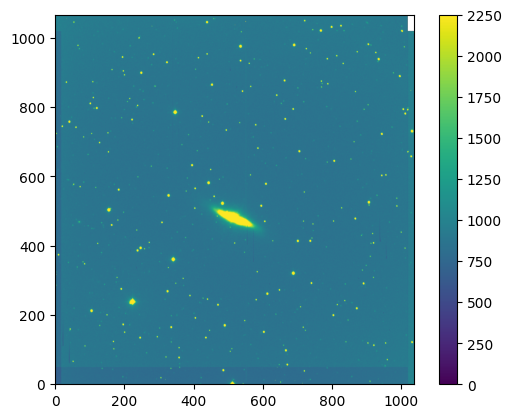

In [ ]:
plt.imshow(cfile, origin='lower', vmin=0, vmax=2250)
plt.colorbar()

Not bad!

If your image does not look nicely aligned, check the sign used to shift your images. Does that offset move your image in the correct direction *relative to your reference image*?

An easy way to check that your offsets have the correct sign is to take the difference between two of the shifted images in your 3D datacube. If the alignment is about right, most the objects in the image should subtract out.

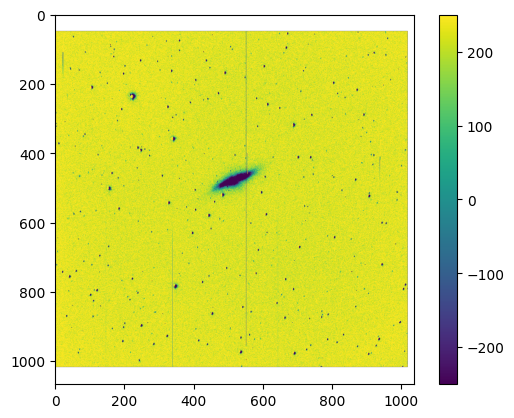

In [ ]:
plt.imshow(cgrid[:,:,0]-cgrid[:,:,1], vmin=-250, vmax=250)
plt.colorbar()

Adjust the numbers in your input file until you are happy with the result.

## Aliging images using array manipulations

```for``` loops are a powerful tool but as we've just seen, they can also be quite slow for large datasets / operations.

Libraries like ```numpy``` can vectorize operations leading to significantly faster run times. Let's take a look at how vectorizing the approach can speed up the run time for our image alignment.

The ```numpy.roll()``` function allows us to shift array elements along an axis.

In [ ]:
my_array = np.arange(10)

In [ ]:
my_array

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
np.roll(my_array, 3)

array([7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

This simple 1D example shows the basic operation - ```numpy``` will shift the array values the specified number of elements in the specified direction. Notice that the values wrap around - that is, now ```7,8,9``` are at the front of the array.

We can do something similar with our images.

In [ ]:
my_image = fits.open('/content/drive/MyDrive/my_ASTR229_data/reduced/m82_vim1.fits')[0].data

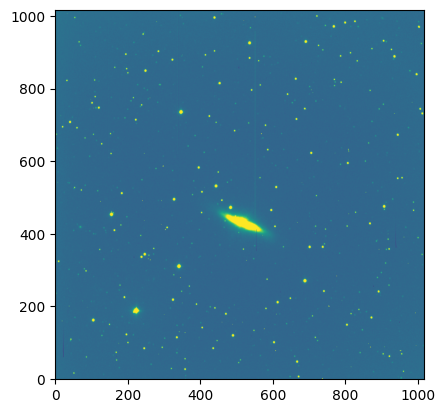

In [ ]:
plt.imshow(my_image, origin='lower', vmin=50, vmax=2500)

Now try shifting the image. We'll do a big shift so it's easy to see what happens.

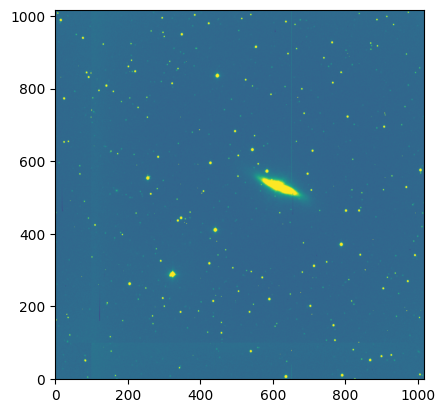

In [ ]:
shifted_image = np.roll(my_image, (100, 100), axis=(0,1))
plt.imshow(shifted_image, origin='lower', vmin=50, vmax=2500)

Careful! When we shift the image array, the values wrap around just as they did in the 1D example. See those two stars that are right next to each other near y=625 in the original image? When we shift the array, they go from the right side of the image to the left side of the image.

We don't want this to happen when we shift our images.
To avoid this problem, we can pad the array with zeros of ```NaNs```. First we need to determine the maximum offsets we need to accommodate.  

In [ ]:
xmax = sdat['xsh'].max() - sdat['xsh'].min()
xmax

np.int64(18)

In [ ]:
ymax = sdat['ysh'].max() - sdat['ysh'].min()
ymax

np.int64(49)

These shifts aren't huge but let's pad by 100 on each side of the array to be safe.

In [ ]:
padded_image = np.pad(my_image, 100, constant_values=np.nan)

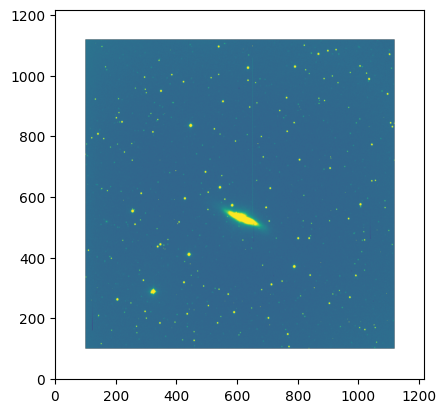

In [ ]:
plt.imshow(padded_image, origin='lower', vmin=50, vmax=2500)

Notice that we set the pad values to ```NaN``` so that they don't contribute to the median.

In [ ]:
padded_image[10,10]

np.float64(nan)

Now let's do the image alignment.

The first steps will look familiar - we need to setup the parameters.

In [ ]:
# read in the first image
ffile=fits.open(path+sdat['name'][0])

# determine the image size using the shape function
ysz, xsz = ffile[0].data.shape

# compute the shift needed for each image
xshift = sdat['xsh']
yshift = sdat['ysh']


Next, shift the images and put them in a 3D array to be combined into a single image.

In [ ]:
#make an empty array to collect the big, shifted images
data_stack = []

start_time = time.time()

# notice that we start with image 1! image 0 is the reference image and does not need to be shifted
for i in range(1,nfiles):
    #read in the image
    ffile=fits.open(path+sdat['name'][i])
    fdata=ffile[0].data

    # add NaNs around the edge of the image so we can shift the images without the data wrapping around on itself
    bgim = np.pad(fdata, 100, constant_values=np.nan)

    # shift the image -- make sure the x and y axes are correctly mapped!
    shift_im = np.roll(bgim, (xshift[i],yshift[i]), axis=(1,0))

    # add to the data stack
    data_stack.append(shift_im)

# make the data stack into an array so we can do math with it
data_stack = np.array(data_stack)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.08322429656982422 seconds ---


Finally, take the median through the stack of shifted images.

In [ ]:
start_time = time.time()
# take the median of the image through the stack direction
# notice that we use np.nanmedian() so that we get the correct medians even where there are NaNs
imstack = np.nanmedian(data_stack, axis=0)
print("--- %s seconds ---" % (time.time() - start_time))

/tmp/ipython-input-368899500.py:4: RuntimeWarning: All-NaN slice encountered
  imstack = np.nanmedian(data_stack, axis=0)


--- 0.6794910430908203 seconds ---


Plot the image to check the result.

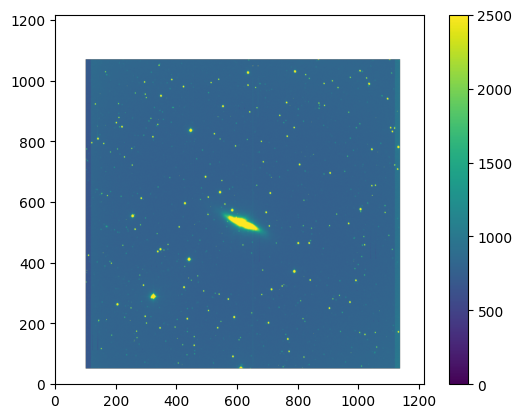

In [ ]:
plt.Figure(figsize=(12,8))
plt.imshow(imstack, origin='lower', vmin=0, vmax=2500)
plt.colorbar()

At this point, you can trim the image to get rid of the extra NaNs around the edges.

# Align and combine

Now that you know the process, align the images in all three filters.

Want to make a 3-color image? You will also have to align the combined V-band, B-band, etc, images with each other.

# Making a three color image

Once all your images are aligned, you can combine them to make a 3-color image in python. We will do this using the ```aplpy``` package. Be sure to check out the [documentation](https://aplpy.readthedocs.io/en/stable/).

If you are running this in colab, you will first have to install ```aplpy```.

In [ ]:
pip install aplpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 545.1/545.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.2/195.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.0/80.0 kB 6.3 MB/s eta 0:00:00


In [ ]:
import aplpy

For this example, we use data from the Hubble 20th Anniversary image. Want to take a look yourself? You can download the high-level science products (HLSPs) from the Milkulski Archive for Space Telescopes (MAST): https://archive.stsci.edu/prepds/carina/wfc3/

In [ ]:
#assign the looong filenames to variables that will be easier to call later

f657n_fn = '/content/drive/MyDrive/ASTR230/example_data/HST_JWST_images/small_halpha.fits'
f673n_fn = '/content/drive/MyDrive/ASTR230/example_data/HST_JWST_images/small_sii.fits'
f502n_fn = '/content/drive/MyDrive/ASTR230/example_data/HST_JWST_images/small_oiii.fits'

In [ ]:
f657n = fits.open(f657n_fn)

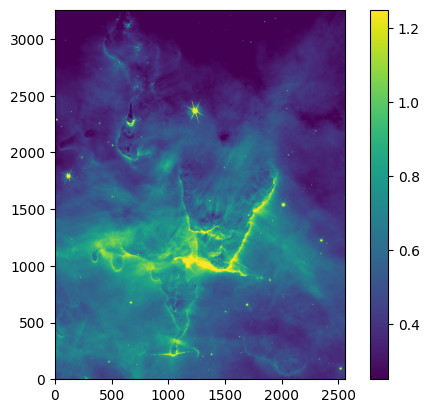

In [ ]:
plt.imshow(f657n[0].data, origin='lower', vmin=0.25, vmax=1.25)
plt.colorbar()

First, we need to combine the separate images into a 3D cube with separate layers for the red, green, and blue channels.

In [ ]:
# Make a 3D cube with the images in RGB order
aplpy.make_rgb_cube([f673n_fn, f657n_fn, f502n_fn], path+'MM_cube.fits')

# Make an RGB image
aplpy.make_rgb_image(path+'MM_cube.fits', path+'MM_rgb.png')

INFO:astropy:Red:
INFO:astropy:vmin =  1.955e-02 (auto)
INFO:astropy:vmax =  2.572e-01 (auto)


INFO: Red: [aplpy.rgb]
INFO: vmin =  1.955e-02 (auto) [aplpy.rgb]
INFO: vmax =  2.572e-01 (auto) [aplpy.rgb]


INFO:astropy:Green:
INFO:astropy:vmin =  1.647e-01 (auto)
INFO:astropy:vmax =  1.289e+00 (auto)


INFO: Green: [aplpy.rgb]
INFO: vmin =  1.647e-01 (auto) [aplpy.rgb]
INFO: vmax =  1.289e+00 (auto) [aplpy.rgb]


INFO:astropy:Blue:
INFO:astropy:vmin =  3.566e-02 (auto)
INFO:astropy:vmax =  3.690e-01 (auto)


INFO: Blue: [aplpy.rgb]
INFO: vmin =  3.566e-02 (auto) [aplpy.rgb]
INFO: vmax =  3.690e-01 (auto) [aplpy.rgb]


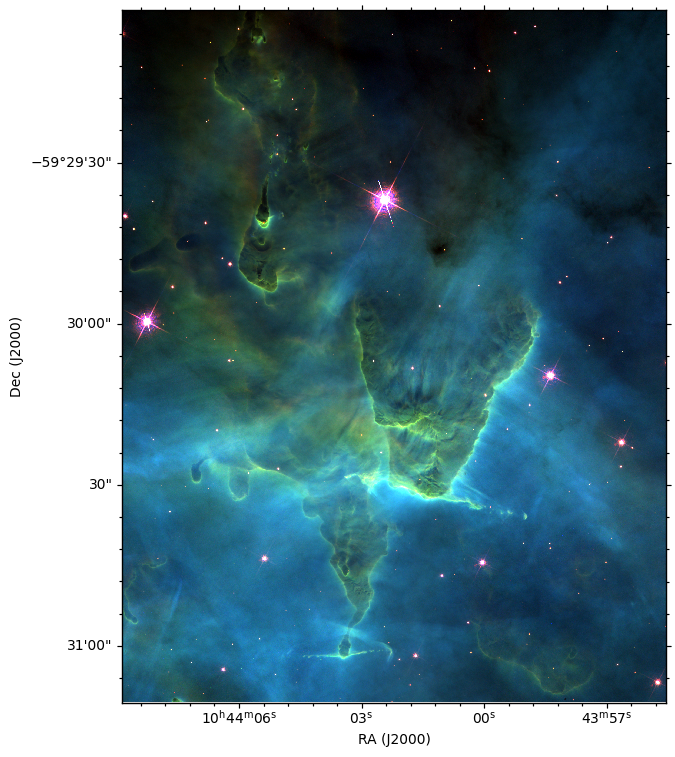

In [ ]:
# Plot the RGB image using one of the three images to indicate the projection
f = aplpy.FITSFigure(f657n_fn)
f.show_rgb(path+'MM_rgb.png')

This already looks pretty good to start but we won't always be this lucky with the first attempt to make a three color image.

You can adjust the image scaling of each image when you make the RGB. This is very similar to adjusting the image scaling for each image in an RGB frame in ds9.

In [ ]:
# Make an RGB image
aplpy.make_rgb_image(path+'MM_cube.fits', path+'MM_rgb.png',
                     vmin_g=0.25, vmax_r=0.13)

INFO:astropy:Red:
INFO:astropy:vmin =  1.903e-02 (auto)
INFO:astropy:vmax =  1.300e-01


INFO: Red: [aplpy.rgb]
INFO: vmin =  1.903e-02 (auto) [aplpy.rgb]
INFO: vmax =  1.300e-01 [aplpy.rgb]


INFO:astropy:Green:
INFO:astropy:vmin =  2.500e-01
INFO:astropy:vmax =  1.342e+00 (auto)


INFO: Green: [aplpy.rgb]
INFO: vmin =  2.500e-01 [aplpy.rgb]
INFO: vmax =  1.342e+00 (auto) [aplpy.rgb]


INFO:astropy:Blue:
INFO:astropy:vmin =  3.546e-02 (auto)
INFO:astropy:vmax =  3.606e-01 (auto)


INFO: Blue: [aplpy.rgb]
INFO: vmin =  3.546e-02 (auto) [aplpy.rgb]
INFO: vmax =  3.606e-01 (auto) [aplpy.rgb]


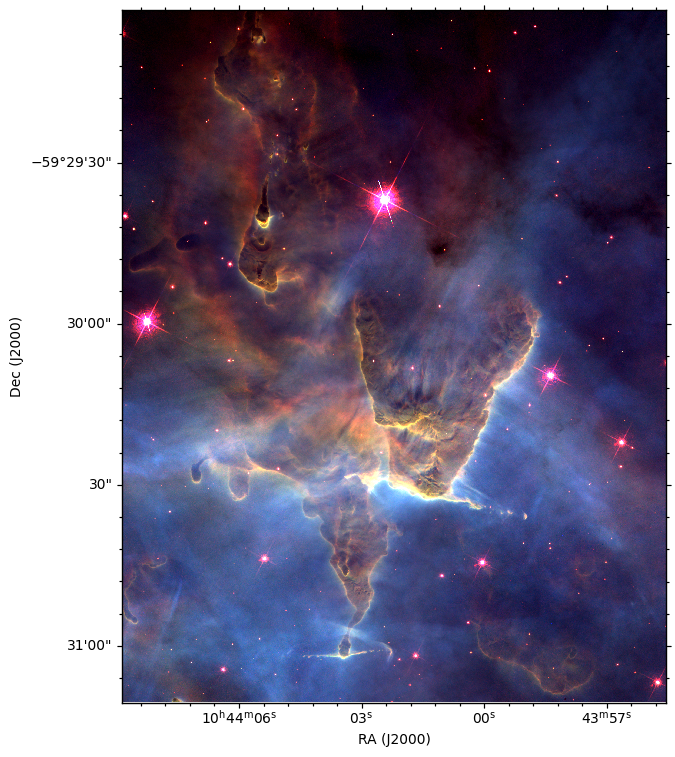

In [ ]:
# Plot the RGB image using one of the three images to indicate the projection
f = aplpy.FITSFigure(f657n_fn)
f.show_rgb(path+'MM_rgb.png')

From here, you can do a lot of things to change and improve the aesthetics of the plot. I usually make the axis and tick labels larger so that they are easy to read. You can also try adding a scale bar and labels, e.g., for the famous jets in the image.

Notice that the image is automatically displayed with the RA and Dec labeled. What information in the image header allows this to happen automatically?